<a href="https://colab.research.google.com/github/mberkancetin/Customizable-Structured-Electronic-Brainwriting/blob/main/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Overview and Welcome


**Purpose:** This Colab notebook is designed for academic and professional researchers to analyze textual data collected via Google Sheets from Customizable Structured Electronic Brainwriting (CSEB) session(s). It provides tools for automatic text classification (Zero-Shot and Few-Shot learning) and further exploratory analyses like Topic Modeling (LDA) and Correspondence Analysis.

**Target Audience:** Researchers who need to categorize or understand themes within a corpus of text responses.

**How to Use This Notebook:**
1. Make a Copy (Recommended): To save your changes and outputs, go to "File" > "Save a copy in Drive".
2. Follow the Steps: Execute the code cells in order from top to bottom.
3. Provide Inputs: You will be prompted to provide your Google Sheet ID and make choices for certain analyses.
4. Interpret Results: Explanations are provided to help you understand the outputs.
5. Adapt (Optional): Feel free to adapt the code for your specific research needs.

**Citation:**
If you use this notebook or the underlying methodology in your research, please consider citing:


# 1. SETUP: Environment and Google Sheet Connection

### Please paste below the Google Sheet ID, sheet name, and column names provided by the Apps Script pop-up.


In [ ]:
spreadsheet_id = "PleaSe3nterY0ur-Spr34dshEetID" #@param {type:"string"}
sheet_name = "PrepData" #@param {type:"string"}
original_column = "RawIdea" #@param {type:"string"}
translate_column = "Translation" #@param {type:"string"}

# If the original language of the session different than NLTK supported languages, keep the language as 'english'.
# We will also show how to preprocess manually with other languages.
# NLTK supported langugages: danish, dutch, finnish, french, german, greek, italian, portuguese, spanish, swedish
# For zero-shot classifications, languages other than English should be found at: https://huggingface.co/models?pipeline_tag=zero-shot-classification

languge = english # @param ["english", "danish", "dutch", "finnish", "french", "german", "greek", "italian", "portuguese", "spanish", "swedish"] {"type":"raw"}

# Indicate category labels of data for zero-shot and few-shot classification methods
category_labels = [
    "Exclusive CR Policies",
    "Reactive CR Policies",
    "Integrative CR Policies",
    "Participative CR Policies"
    ]

# 2. IMPORTS

### This cell installs Python packages required for the analysis.
(Self-correction: If any package installation requires a kernel restart, place that !pip install in its own cell right at the top, run it, let it restart, and then run subsequent cells. For most common libraries like pandas, gspread, scikit-learn, transformers, sentence-transformers, setfit, Colab often has them or handles updates gracefully. Explicitly state if a restart is common for a specific package).

In [ ]:
# Run this cell to install required libraries.

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from transformers import pipeline
import torch

!pip install setfit
from setfit import SetFitModel, Trainer

!pip install prince
import prince  # For correspondence analysis
from scipy.stats import chi2_contingency

import gspread
from google.auth import default
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.service_account import ServiceAccountCredentials

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

import string
import re
import urllib.request
import pickle
import os
os.environ["WANDB_DISABLED"] = "true"

!pip install nltk
!pip install Levenshtein

import nltk
from nltk.metrics.distance import edit_distance
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tag import PerceptronTagger, hmm, CRFTagger
import Levenshtein

# Download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 3. LOAD DATA: Authenticate and Connect to Google Sheets

### Spreadsheet to Colab connection is done, data is transformed to be a pandas DataFrame. Another function, **write_results_to_sheets**, to write back to the spreadsheet is defined.

### Before analysis, we'll select the appropriate text column (original or translated) and perform a basic exploration. Use **translated_df** DataFrame if ideas are translated, and if not, use **original_df** DataFrame.

In [ ]:
# Authentication and setup
def connect_to_sheets():
    auth.authenticate_user()
    creds, _ = default()

    # Connect to Google Sheets
    gc = gspread.authorize(creds)
    return gc

# Load data from Google Sheets
def load_ideas_from_sheets(spreadsheet_id, sheet_name):
    gc = connect_to_sheets()
    sh = gc.open_by_key(spreadsheet_id)
    worksheet = sh.worksheet(sheet_name)
    data = worksheet.get_all_values()

    # Assuming the first row contains headers
    headers = data[0]
    ideas_data = data[1:]

    # Create DataFrame
    df = pd.DataFrame(ideas_data, columns=headers)
    return df

def write_results_to_sheets(spreadsheet_id, processed_data, new_worksheet_name):
    """
    Write processed data back to a new worksheet in the same Google Sheets file.

    Parameters:
    - spreadsheet_id: The ID of the Google Sheets document
    - original_sheet_name: Name of the original worksheet
    - processed_data: DataFrame containing the processed results
    - new_worksheet_name: Name of the new worksheet to create

    Returns:
    - The newly created worksheet object
    write_results_to_sheets(spreadsheet_id, results_df, 'Processed_Results')
    """
    gc = connect_to_sheets()

    # Open the spreadsheet
    sh = gc.open_by_key(spreadsheet_id)

    # Check if worksheet already exists
    try:
        # If worksheet exists, delete it to avoid duplicates
        existing_worksheet = sh.worksheet(new_worksheet_name)
        sh.del_worksheet(existing_worksheet)
    except gspread.WorksheetNotFound:
        # Worksheet doesn't exist, which is fine
        pass

    # Create a new worksheet
    new_worksheet = sh.add_worksheet(title=new_worksheet_name, rows=processed_data.shape[0]+1, cols=processed_data.shape[1])

    # Prepare the data for writing
    # Convert DataFrame to list of lists, including headers
    data_to_write = [processed_data.columns.tolist()] + processed_data.values.tolist()

    # Write the data to the new worksheet
    new_worksheet.update(range_name='A1', value=data_to_write)
    print(f"Successfully wrote results to new worksheet: {new_worksheet_name}")

    return new_worksheet


# DataFrame is loaded with two columns
df = load_ideas_from_sheets(spreadsheet_id, sheet_name)
original_df = df[original_column]
translated_df = df[translate_column]


# 4. AUTOMATIC CLASSIFICATION METHODS

### This section applies machine learning models to automatically classify your text data into predefined categories. You can choose between Zero-Shot Classification (no example data needed from you for training) or Few-Shot Classification (requires a small number of labeled examples).



## 4.1 Define Category Labels for Classification

### Regardless of the method chosen below, you need to define the categories (labels) you want to classify your text into.

In [ ]:
#@markdown ⬇️ **Enter your classification labels, separated by commas:**
#@markdown (e.g., "Customer Complaint, Feature Request, Positive Feedback, Question")
CANDIDATE_LABELS_STR = "Exclusive CR Policies, Reactive CR Policies, Integrative CR Policies, Participative CR Policies" #@param {type:"string"}
candidate_labels = [label.strip() for label in CANDIDATE_LABELS_STR.split(',')]

if not candidate_labels or all(not lab for lab in candidate_labels):
    print("⚠️ Please define your candidate labels above.")
else:
    print("Using the following labels for classification:")
    for i, label in enumerate(candidate_labels):
        print(f"{i}: {label}")

Using the following labels for classification:
0: Exclusive CR Policies
1: Reactive CR Policies
2: Integrative CR Policies
3: Participative CR Policies


## **4.2 Method 1: Zero-Shot Classification**

### Zero-shot classification allows you to classify text into labels the model hasn't explicitly been trained on, by leveraging large pre-trained language models. It's useful when you don't have labeled training data.
### **Reference:**



### This typically uses models like BART fine-tuned on Natural Language Inference (NLI). See Hugging Face Transformers documentation.

In [ ]:
#@markdown ⬇️ **Select a Zero-Shot Classification model:**
#@markdown (Common choices: 'facebook/bart-large-mnli', 'valhalla/distilbart-mnli-12-3', 'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli')
ZERO_SHOT_MODEL_NAME = "facebook/bart-large-mnli"  #@param {type:"string"}

#@markdown ⬇️ **Run Zero-Shot Classification?**
RUN_ZERO_SHOT = True #@param {type:"boolean"}

def zero_shot_idea_classification(idea_column, candidate_labels, model):
    """
    Classify session ideas into predefined categories
    """
    # Zero-shot classification pipeline
    classifier = pipeline(
        "zero-shot-classification",
        model=model
    )

    # Classification function
    def classify_idea(idea):
        result = classifier(idea, candidate_labels)
        return result

    # Create results DataFrame
    return {
        'result': [classify_idea(idea) for idea in idea_column]
    }

if RUN_ZERO_SHOT:
    try:
        org_results = zero_shot_idea_classification(original_df, category_labels, ZERO_SHOT_MODEL_NAME)
        en_results = zero_shot_idea_classification(translated_df, category_labels, ZERO_SHOT_MODEL_NAME)
        results = en_results

        result_df = pd.DataFrame([
            {'sequence': item['sequence'], **dict(zip(item['labels'], item['scores']))}
            for item in results['result']
        ])
        result_df.iloc[:, 1:] = result_df.iloc[:, 1:].astype(float)
        result_df["Topic"] = result_df.iloc[:, 1:].apply(lambda row: row.idxmax(), axis=1)

        print("Zero-Shot classification complete.")

        print("\n--- Zero-Shot Classification Results ---")
        display(result_df)

        print("\n--- Label Distribution ---")
        display(result_df['labels'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

        plt.figure(figsize=(10, 6))
        sns.countplot(y='zero_shot_label', data=result_df, order=result_df['labels'].value_counts().index, palette="viridis")
        plt.title('Distribution of Zero-Shot Classified Labels')
        plt.xlabel('Count')
        plt.ylabel('Label')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred during Zero-Shot classification: {e}")
else:
    print("Skipping Zero-Shot Classification.")

In [ ]:
def zero_shot_idea_classification(idea_column, candidate_labels):
    """
    Classify session ideas into predefined categories
    """
    # Zero-shot classification pipeline
    classifier = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli"
    )

    # Classification function
    def classify_idea(idea):
        result = classifier(idea, candidate_labels)
        return result

    # Create results DataFrame
    return {
        'result': [classify_idea(idea) for idea in idea_column]
    }

In [ ]:
org_results = zero_shot_idea_classification(original_df, category_labels)
en_results = zero_shot_idea_classification(translated_df, category_labels)
results = en_results

Device set to use cpu


In [ ]:
result_df = pd.DataFrame([
    {'sequence': item['sequence'], **dict(zip(item['labels'], item['scores']))}
    for item in results['result']
])
result_df.iloc[:, 1:] = result_df.iloc[:, 1:].astype(float)
result_df["Topic"] = result_df.iloc[:, 1:].apply(lambda row: row.idxmax(), axis=1)
result_df

,sequence,Collaborational Element,Regulational Element,Operational Element,Movemental Element,Max
0,Giving additional bonuses and rewards based on...,0.324456,0.240434,0.222079,0.213031,Collaborational Element
1,Contributing to retirement plans.,0.551339,0.148363,0.145134,0.155164,Collaborational Element
2,Making ergonomic arrangements in the workplace.,0.216121,0.098303,0.336030,0.349546,Movemental Element
3,Creating more green spaces or rest areas in th...,0.302296,0.187368,0.251805,0.258531,Collaborational Element
4,Making investments to reduce carbon emissions.,0.379928,0.215860,0.241426,0.162786,Collaborational Element
...,...,...,...,...,...,...
103,"I want the products I buy to be long-lasting, ...",0.306418,0.292528,0.187711,0.213343,Collaborational Element
104,Accurate Information to the Consumer: Providin...,0.346266,0.275006,0.248134,0.130594,Collaborational Element
105,Sustainable Production: Carrying out productio...,0.292177,0.208181,0.190688,0.308954,Movemental Element
106,Publication of Ethical Audit Results: Sharing ...,0.545124,0.170590,0.138826,0.145460,Collaborational Element


In [ ]:
write_results_to_sheets(spreadsheet_id, result_df, "zero_shot_classification")

<ipython-input-56-e65d2b712665>:105: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  new_worksheet.update('A1', data_to_write)


Successfully wrote results to new worksheet: zero_shpt_classification


<Worksheet 'zero_shpt_classification' id:2098316263>

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

# We select a subsample of 5000 abstracts from ArXiv
dataset = load_dataset("CShorten/ML-ArXiv-Papers")["train"]
docs = dataset["abstract"][:5_000]

# We define a number of topics that we know are in the documents
zeroshot_topic_list = ["Clustering", "Topic Modeling", "Large Language Models"]

# We fit our model using the zero-shot topics
# and we define a minimum similarity. For each document,
# if the similarity does not exceed that value, it will be used
# for clustering instead.
topic_model = BERTopic(
    embedding_model="thenlper/gte-small",
    min_topic_size=15,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.85,
    representation_model=KeyBERTInspired()
)
topics, _ = topic_model.fit_transform(docs)

## **4.3 Method 2: Few-Shot Classification**

### SetFit allows for training a sentence transformer model with very few labeled examples per class. This can often yield better results than zero-shot if you can provide a small, high-quality set of examples.

### **Reference:**
Tunstall, L., et al. (2022). Efficient Few-Shot Learning Without Prompts. arXiv:2209.11055. https://doi.org/10.48550/arxiv.2209.11055

Sentence-BERT: Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. EMNLP. http://arxiv.org/abs/1908.10084

In [ ]:
#@markdown ⬇️ **Select a Sentence Transformer model for SetFit:**
#@markdown (e.g., 'sentence-transformers/paraphrase-mpnet-base-v2', 'sentence-transformers/all-MiniLM-L6-v2', 'dbmdz/bert-base-turkish-cased' for Turkish)
SETFIT_MODEL_NAME = "sentence-transformers/paraphrase-mpnet-base-v2" #@param {type:"string"}

#@markdown ⬇️ **Run Few-Shot Classification (SetFit)?**
RUN_FEW_SHOT = False #@param {type:"boolean"}


# Provide a few examples (e.g., 4-16) for each category.
few_shot_examples_df = pd.DataFrame({
    'text': [
                "Companies should invest in projects that will support the local economy",
                "Companies should prioritize workers' rights, health and safety",
                "Consumers should be informed about recycling",
                "Discrimination against workers exercising their right to organize should be prevented",
                "Education and vocational skills development programs should be offered to local people",
                "Fabrics must be long-lasting and durable, and they must be recycled",
                "Flexible payment plans should be offered against price increases",
                "Investments should be made in sustainable technology development processes",
                "Occupational safety practices should be implemented at high standards",
                "Overtime payments should be guaranteed and notice and compensation rights should be strengthened",
                "Public relations activities should be carried out regularly regarding the ethical and social responsibilities of the company",
                "The company must ensure transparency through audits and reporting",
                "The company should design its social responsibility projects according to the reactions received",
                "To ensure stakeholder participation, an anonymous complaint system should be established and free legal consultancy should be offered",
                "Women's rights awareness projects should be implemented within the company",
                "Workforce quality should be improved through training programs for employees",
              ],
    'label': [
                3, 0, 3, 1,
                3, 2, 0, 2,
                2, 0, 1, 2,
                1, 3, 1, 0,
              ]
})



,text,label
0,Companies should invest in projects that will ...,3
1,"Companies should prioritize workers' rights, h...",0
2,Consumers should be informed about recycling,3
3,Discrimination against workers exercising thei...,1
4,Education and vocational skills development pr...,3
5,"Fabrics must be long-lasting and durable, and ...",2
6,Flexible payment plans should be offered again...,0
7,Investments should be made in sustainable tech...,2
8,Occupational safety practices should be implem...,2
9,Overtime payments should be guaranteed and not...,0


In [ ]:
def few_shot_classification_with_setfit(idea_column, candidate_labels, few_shot_examples, model):
    """
    Perform few-shot classification using SetFit with a classification head.

    Parameters:
    - idea_column: Series of ideas to classify
    - candidate_labels: List of possible classification labels
    - few_shot_examples: DataFrame containing 'text' and 'label' columns
    - model: Hugging Face model for classification (SetFit model)

    Returns:
    - DataFrame with classification results including predicted label and confidence
    """
    # Load the pre-trained SetFit model
    model = SetFitModel.from_pretrained(model)

    # Prepare the few-shot examples for training
    X_train = few_shot_examples['text'].tolist()
    y_train = few_shot_examples['label'].astype(int).tolist()

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    # Convert to Hugging Face datasets
    from datasets import Dataset

    train_data = {'text': X_train, 'label': y_train}
    val_data = {'text': X_val, 'label': y_val}

    train_dataset = Dataset.from_dict(train_data)
    eval_dataset = Dataset.from_dict(val_data)

    # Set up the Trainer with the model, training dataset, and validation dataset
    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    # Train the model
    trainer.train()

    # Classify each idea in the column
    results = []
    for idea in idea_column:
        # Perform the classification using the trained model
        result = model.predict_proba([idea])

        # Apply softmax to get probabilities (confidence scores)
        probs = torch.nn.functional.softmax(result, dim=-1)

        # Get the predicted labels (index of the max probability)
        predictions = np.argmax(probs.numpy(), axis=1)
        predictions = predictions.apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x)

        # Get the confidence scores for the top label
        confidence_scores = np.max(probs.numpy(), axis=1)
        confidence_scores = confidence_scores.apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x)

        results.append({
            'idea': idea,
            'predicted_label': predictions,
            'confidence': confidence_scores
        })

    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    return df_results

def visualize_classification_results(df_results):
    """
    Create interactive visualizations for classification results

    Parameters:
    - df_results: DataFrame with classification results

    Returns:
    - Plotly figure objects
    """
    # Scatter Plot with TSNE dimensionality reduction
    # Convert categorical labels to numeric for visualization
    df_results['label_code'] = pd.Categorical(df_results['predicted_label']).codes

    # Perform TSNE to reduce dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(
        pd.get_dummies(df_results[['label_code', 'confidence']])
    )

    df_results['tsne_x'] = tsne_results[:, 0]
    df_results['tsne_y'] = tsne_results[:, 1]

    # Scatter Plot
    scatter_fig = px.scatter(
        df_results,
        x='tsne_x',
        y='tsne_y',
        color='predicted_label',
        size='confidence',
        hover_data=['idea', 'predicted_label', 'confidence'],
        title='Idea Classification Visualization',
        labels={'tsne_x': 'Dimension 1', 'tsne_y': 'Dimension 2'}
    )

    # Pie Chart of Label Distribution
    label_counts = df_results['predicted_label'].value_counts()
    pie_fig = px.pie(
        values=label_counts.values,
        names=label_counts.index,
        title='Classification Label Distribution'
    )

    # Confidence Box Plot
    box_fig = px.box(
        df_results,
        x='predicted_label',
        y='confidence',
        title='Confidence Levels by Label'
    )

    return scatter_fig, pie_fig, box_fig

In [ ]:
if RUN_FEW_SHOT:
    try:
        df_results = few_shot_classification_with_setfit(translated_df, category_labels, few_shot_examples_df, SETFIT_MODEL_NAME)

        print("Few-Shot classification complete.")

        print("\n--- Few-Shot Classification Results ---")
        display(result_df)

        print("\n--- Label Distribution ---")
        display(result_df['labels'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

        plt.figure(figsize=(10, 6))
        sns.countplot(y='zero_shot_label', data=result_df, order=result_df['labels'].value_counts().index, palette="viridis")
        plt.title('Distribution of Zero-Shot Classified Labels')
        plt.xlabel('Count')
        plt.ylabel('Label')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred during Few-Shot classification: {e}")
else:
    print("Skipping Few-Shot Classification.")


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1682
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.248100
50,0.140400
100,0.021000


,idea,predicted_label,confidence
0,Giving additional bonuses and rewards based on...,[0],[0.3788292153583287]
1,Contributing to retirement plans.,[0],[0.3694043267877012]
2,Making ergonomic arrangements in the workplace.,[2],[0.32109958447397163]
3,Creating more green spaces or rest areas in th...,[2],[0.2907168506484963]
4,Making investments to reduce carbon emissions.,[2],[0.4457862898829392]
...,...,...,...
103,"I want the products I buy to be long-lasting, ...",[2],[0.4552234515173392]
104,Accurate Information to the Consumer: Providin...,[3],[0.37294162013446625]
105,Sustainable Production: Carrying out productio...,[2],[0.4606468278023944]
106,Publication of Ethical Audit Results: Sharing ...,[2],[0.33058839781744237]


In [ ]:
# Flatten the 'predicted_label' and 'confidence' columns
df_results["predicted_label"] = df_results["predicted_label"].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x)
df_results["confidence"] = df_results["confidence"].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x)

# Now write to Google Sheets
write_results_to_sheets(spreadsheet_id, df_results, "few_shot_classification2")

Successfully wrote results to new worksheet: few_shot_classification2


<ipython-input-13-7b900704e498>:113: DeprecationWarning:

The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)



<Worksheet 'few_shot_classification2' id:2095161906>

In [ ]:
# Visualize results
scatter_fig, pie_fig, box_fig = visualize_classification_results(df_results)

scatter_fig.show()

In [ ]:
org_few_shot_examples_df = pd.DataFrame({
    'text': [
                "Firmalar yerel ekonomiyi destekleyecek projelere yatırım yapmalı",
                "Şirketler işçi haklarına, sağlığına ve güvenliğine öncelik vermeli",
                "Tüketiciler geri dönüşüm konusunda bilgilendirilmeli",
                "Örgütlenme hakkını kullanan işçilere yönelik ayrımcılık önlenmelidir",
                "Yerel halka eğitim ve mesleki beceri geliştirme programları sunulmalı",
                "Kumaşların uzun ömürlü ve dayanıklı olması ve geri dönüştürülmesi gerekiyor",
                "Fiyat artışlarına karşı esnek ödeme planları sunulmalı",
                "Sürdürülebilir teknoloji geliştirme süreçlerine yatırım yapılmalı",
                "İş güvenliği uygulamaları yüksek standartlarda hayata geçirilmeli",
                "Fazla mesai ödemeleri garanti altına alınmalı, ihbar ve tazminat hakları güçlendirilmeli",
                "Şirketin etik ve sosyal sorumluluklarını gözeterek halkla ilişkiler faaliyetleri düzenli olarak yürütülmelidir",
                "Şirket denetim ve raporlama yoluyla şeffaflığı sağlamalıdır",
                "Firma sosyal sorumluluk projelerini gelen tepkilere göre tasarlamalı",
                "Paydaş katılımının sağlanması için isimsiz şikayet sistemi kurulmalı ve ücretsiz hukuki danışmanlık sunulmalıdır",
                "Şirket içinde kadın haklarına yönelik farkındalık projeleri hayata geçirilmeli",
                "Çalışanlara yönelik eğitim programları ile iş gücü kalitesi artırılmalıdır"
              ],
    'label': [
                3, 0, 3, 1,
                3, 2, 0, 2,
                2, 0, 1, 2,
                1, 3, 1, 0,
              ]
})


In [ ]:
org_df_results = few_shot_classification_with_setfit(original_df, category_labels, load_ideas_from_sheets(spreadsheet_id, "Sheet2"), "dbmdz/bert-base-turkish-cased")

org_df_results

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1698
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.257000
50,0.187000
100,0.028800


,idea,predicted_label,confidence
0,Performansa dayalı ek prim ve ödüller verilmesi.,[0],[0.47366812428834626]
1,Emeklilik planlarına katkı sağlanması.,[0],[0.46917402420052545]
2,İş yerinde ergonomik düzenlemeler yapılması.,[2],[0.45689284996561863]
3,İş yerinde daha fazla yeşil alan veya dinlenme...,[3],[0.3823510802895104]
4,Karbon emisyonlarını azaltmaya yönelik yatırım...,[2],[0.47485464042711206]
...,...,...,...
120,"""The company must ensure transparency through ...",[3],[0.4228770542442241]
121,"""The company should design its social responsi...",[3],[0.3504817302729704]
122,"""To ensure stakeholder participation, an anony...",[2],[0.32871673695661097]
123,"""Women's rights awareness projects should be i...",[3],[0.431316131727887]


In [ ]:
# Now write to Google Sheets
# write_results_to_sheets(spreadsheet_id, org_df_results, "few_shot_classification_org2")

In [ ]:
# Visualize results
scatter_fig, pie_fig, box_fig = visualize_classification_results(org_df_results)

# In Colab, you would display these:
scatter_fig.show()
pie_fig.show()
box_fig.show()

# 6. FURTHER ANALYSIS AFTER CLASSIFICATION

### After classifying your data, you might want to perform further analyses like topic modeling on the text within specific categories, or correspondence analysis to see relationships between categories and other variables.
### **Note:** These analyses often benefit from text preprocessing like tokenization, lemmatization, and stop-word removal.

## **6.1 Text Preprocessing for Advanced Analysis**

### This step prepares the text for models like LDA, BIRCH, Multidimensional Scaling, TF-IDF Analysis, and Correspondence Analysis. It involves tokenization, lowercasing, removing punctuation and stop words, and lemmatization.

Preprocessing English text

In [ ]:
# Enhanced synonym and topic mapping
synonym_groups = {
    'audit': ['inspection', 'examination'],
    'standard': ['guideline', 'protocol', 'benchmark'],
    'report': ['document', 'summary', 'analysis'],
    'comply': ['adhere', 'follow', 'conform'],
    'labor': ['workforce', 'employment', 'work'],
    'worker': ['employee', 'employees', 'workers', 'collar'],
    'environmental': ['ecology', 'sustainability', 'green'],
    'salary': ['wage', 'pay', 'wages', 'payment']
}

# Additional stopwords
additional_stops = {
    'employee', 'work', 'make', 'take', 'provide', 'instead',
    'use', 'give', 'without', 'right',
    'increase', 'prevent', 'support', 'area'
}



def preprocess_text(text_series):
    # Convert to lowercase and remove whitespaces
    processed = text_series.str.strip().str.lower()

    # Remove punctuation and numbers
    processed = processed.str.replace(r'[^\w\s]', '', regex=True)
    processed = processed.str.replace(r'\d+', '', regex=True)

    # Prepare stopwords and lemmatizer
    stop_words = set(stopwords.words(languge))
    lemmatizer = WordNetLemmatizer()

    def preprocess_single_text(text):
        # Split into words
        words = text.split()

        # Remove stopwords
        words = [word for word in words if word not in stop_words]

        # Replace synonyms with canonical terms
        transformed_words = []
        for word in words:
            replaced = False
            for canonical, synonyms in synonym_groups.items():
                if word in synonyms or word == canonical:
                    transformed_words.append(canonical)
                    replaced = True
                    break
            if not replaced and word not in additional_stops:
                transformed_words.append(word)

        # Lemmatize words (first as verbs, then as nouns)
        lemmatized_words = [
            lemmatizer.lemmatize(word, pos='v')
            for word in transformed_words
        ]

        lemmatized_words = [
            lemmatizer.lemmatize(word, pos='n')
            for word in lemmatized_words
        ]

        # Join words back into a string
        return ' '.join(lemmatized_words)

    # Apply preprocessing to each text in the series
    processed = processed.apply(preprocess_single_text)

    return processed

en_processed = preprocess_text(en_ideas)

# 6.2 Latent Dirichlet Allocation (LDA) Topic Modeling

### LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. It's commonly used to discover abstract "topics" that occur in a collection of documents.

In [ ]:
#@markdown ---
#@markdown ⬇️ **Run LDA Topic Modeling?**
RUN_LDA = False #@param {type:"boolean"}

# Main analysis function
def analyze_ideas_lda(raw_ideas, processed_ideas, n_topics=4):
        vectorizer = CountVectorizer(
        max_df=0.8,      # Reduced to allow more diverse terms
        min_df=3,        # Increased to filter out very rare terms
        max_features=1500,  # Increased feature space
        stop_words=list(additional_stops)
    )
    dtm = vectorizer.fit_transform(processed_ideas)

    # Create and fit improved LDA model
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method='online',
        max_iter=20,         # Increased iterations
        learning_offset=50., # Helps with online learning
        learning_decay=0.7,  # More gradual learning
        doc_topic_prior=None,  # Let model learn topic distributions
        topic_word_prior=None  # Let model learn word distributions
    )
    lda_output = lda_model.fit_transform(dtm)

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Topic-word distribution with improved display
    def display_topics(model, feature_names, n_top_words):
        topic_dict = {}
        for topic_idx, topic in enumerate(model.components_):
            # Get top words with their weights
            top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
            topic_words = [
                (feature_names[i], round(topic[i], 3))
                for i in top_words_indices
            ]
            topic_dict[f"Topic {topic_idx+1}"] = topic_words
        return topic_dict

    # Display top words for each topic
    topic_words = display_topics(lda_model, feature_names, 10)

    # Document-topic distribution
    doc_topic_df = pd.DataFrame(lda_output)
    doc_topic_df.columns = [f'Topic {i+1}' for i in range(n_topics)]

    # Add original ideas and dominant topic
    doc_topic_df['Idea'] = raw_ideas.values
    doc_topic_df['Dominant_Topic'] = doc_topic_df.iloc[:, :n_topics].idxmax(axis=1)

    # Calculate frequency of each topic
    topic_counts = doc_topic_df['Dominant_Topic'].value_counts().reset_index()
    topic_counts.columns = ['Topic', 'Count']

    # Return results
    results = {
        'topic_words': topic_words,
        'doc_topic_distribution': doc_topic_df,
        'topic_counts': topic_counts,
        'raw_ideas': raw_ideas,
        'processed_ideas': processed_ideas
    }

    return results

# Function to analyze proximity to predefined topic groups
def analyze_proximity_to_topics(doc_topic_df, predefined_topics):
    """
    Analyze how LDA topics align with predefined topic groups

    Parameters:
    - doc_topic_df: DataFrame with document-topic distributions
    - predefined_topics: Dictionary with topic names as keys and lists of keywords as values

    Returns:
    - DataFrame showing alignment between LDA topics and predefined topics
    """
    # Create a matrix to store similarity scores
    similarity_matrix = np.zeros((len(predefined_topics), len(predefined_topics)))
    # Get the top words for each LDA topic
    lda_topic_words = list(doc_topic_df.iloc[:, :4].idxmax(axis=1).unique())

    # For each predefined topic and each LDA topic, calculate similarity
    for i, (topic_name, keywords) in enumerate(predefined_topics.items()):
        for j, lda_topic in enumerate(range(4)):
            # Calculate similarity score (e.g., based on keyword overlap)
            # This is a simple example - you can use more sophisticated methods
            topic_ideas = doc_topic_df[doc_topic_df.iloc[:, :4].idxmax(axis=1) == f'Topic {j+1}']['Idea']

            # Count how many ideas in this topic contain the keywords
            keyword_matches = 0
            for idea in topic_ideas:
                for keyword in keywords:
                    if keyword.lower() in idea.lower():
                        keyword_matches += 1
                        break

            if len(topic_ideas) > 0:
                similarity_matrix[i, j] = keyword_matches / len(topic_ideas)
            else:
                similarity_matrix[i, j] = 0

    # Create DataFrame for the similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix,
                               index=predefined_topics.keys(),
                               columns=[f'Topic {i+1}' for i in range(4)])

    return similarity_df

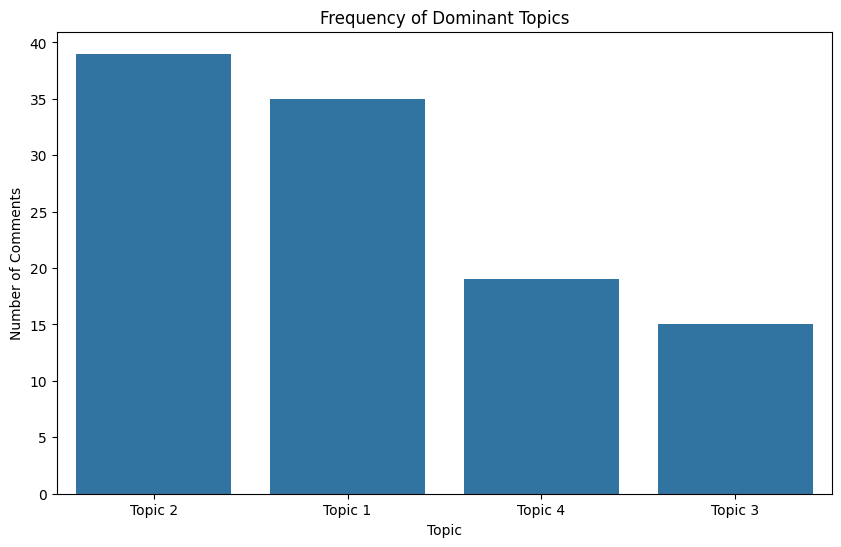

Top words for each LDA topic:
Topic 1: employee, information, provide, product, local, right, worker, salary, increase, establish
Topic 2: employee, labor, production, child, local, use, lowcost, provide, pay, female
Topic 3: environmental, chain, report, audit, supply, production, work, ethical, comply, fair
Topic 4: work, area, provide, project, support, company, condition, program, workplace, prevent

Topic distribution across comments:
     Topic  Count
0  Topic 2     39
1  Topic 1     35
2  Topic 4     19
3  Topic 3     15

Alignment with predefined topic groups:
                          Topic 1   Topic 2   Topic 3   Topic 4
Operational Element      0.314286  0.487179  0.133333  0.157895
Movemental Element       0.057143  0.128205  0.066667  0.052632
Regulational Element     0.057143  0.025641  0.466667  0.000000
Collaborational Element  0.085714  0.102564  0.000000  0.315789


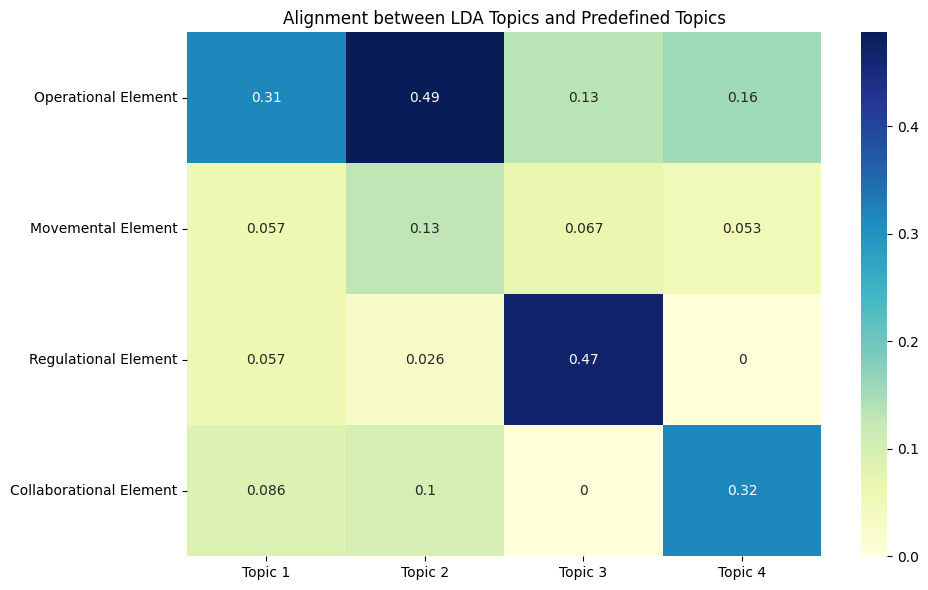

In [ ]:
if RUN_LDA:
  # Run LDA analysis with tanslations
  en_results = analyze_ideas_lda(en_ideas, en_processed, n_topics=4)

  # Analyze proximity to predefined topics
  ### proximity_df = analyze_proximity_to_topics(en_results['doc_topic_distribution'], org_predefined_topics)
  proximity_df = analyze_proximity_to_topics(en_results['doc_topic_distribution'], en_predefined_topics)

  # Display en_results
  print("Top words for each LDA topic:")
  for topic, words in en_results['topic_words'].items():
      print(f"{topic}: {', '.join(words)}")

  print("\nTopic distribution across ideas:")
  print(en_results['topic_counts'])

  # Visualization of topic distribution
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Topic', y='Count', data=en_results['topic_counts'])
  plt.title('Frequency of Dominant Topics')
  plt.xlabel('Topic')
  plt.ylabel('Number of Ideas')
  plt.tight_layout()
  plt.show()
else:
  print("Skipping LDA Topic Modeling.")

In [ ]:
print("\nAlignment with predefined topic groups:")
print(proximity_df)

# Visualize alignment
plt.figure(figsize=(10, 6))
sns.heatmap(proximity_df, annot=True, cmap="YlGnBu")
plt.title('Alignment between LDA Topics and Predefined Topics')
plt.tight_layout()
plt.show()

In [ ]:
en_results["doc_topic_distribution"]


,Topic 1,Topic 2,Topic 3,Topic 4,Comment,Dominant_Topic
0,0.874412,0.041822,0.041867,0.041898,Giving additional bonuses and rewards based on...,Topic 1
1,0.064330,0.807399,0.063091,0.065180,Contributing to retirement plans.,Topic 2
2,0.065421,0.800678,0.063972,0.069929,Making ergonomic arrangements in the workplace.,Topic 2
3,0.062992,0.063381,0.062657,0.810970,Creating more green spaces or rest areas in th...,Topic 4
4,0.089679,0.738515,0.085891,0.085915,Making investments to reduce carbon emissions.,Topic 2
...,...,...,...,...,...,...
103,0.052627,0.846893,0.050188,0.050292,"I want the products I buy to be long-lasting, ...",Topic 2
104,0.926277,0.023630,0.027049,0.023045,Accurate Information to the Consumer: Providin...,Topic 1
105,0.036848,0.038154,0.888704,0.036294,Sustainable Production: Carrying out productio...,Topic 3
106,0.042073,0.041728,0.874428,0.041772,Publication of Ethical Audit Results: Sharing ...,Topic 3


# 6.3 Correspondence Analysis (CA)

### Correspondence Analysis is a statistical technique that provides a graphical representation of the relationships between rows and columns of a contingency table. For example, you could explore the relationship between your classified labels (e.g., 'zero_shot_label') and another categorical variable in your dataset, or between LDA topics and another variable.

In [ ]:
df["en_processed"] = en_processed
correspondance_df = df.loc[:, ["en_processed", "Category"]]
correspondance_df['Category'] = correspondance_df['Category'].astype(dtype="int8")

In [ ]:
def perform_correspondence_analysis(contingency_table):
    """
    Perform correspondence analysis on a contingency table

    Parameters:
    - contingency_table: DataFrame with counts

    Returns:
    - ca: Correspondence analysis object
    - statistics: Dictionary with CA statistics
    """
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate total observations
    n = contingency_table.values.sum()

    # Calculate phi^2 (effect size)
    phi2 = chi2 / n

    # Create CA model
    ca = prince.CA(
        n_components=min(contingency_table.shape) - 1,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    # Fit the model
    ca_result = ca.fit(contingency_table)
    # print(dir(ca_result))

    # Get eigenvalues and explained inertia
    eigenvalues = ca_result.eigenvalues_
    explained_inertia = ca_result.percentage_of_variance_
    cumulative_inertia = ca_result.cumulative_percentage_of_variance_

    # Create eigenvalue summary table
    eigenvalue_summary = pd.DataFrame({
        'Dimension': [f'Dim {i+1}' for i in range(len(eigenvalues))],
        'Eigenvalue': eigenvalues,
        'Percentage of Inertia': explained_inertia,
        'Cumulative Percentage': cumulative_inertia
    })

    # Calculate high phi2 threshold (Greenacre's recommendation)
    high_phi2_threshold = 1/min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)

    # Collect statistics
    statistics = {
        'n': n,
        'chi2': chi2,
        'p_value': p,
        'dof': dof,
        'phi2': phi2,
        'high_phi2_threshold': high_phi2_threshold,
        'eigenvalue_summary': eigenvalue_summary
    }

    return ca_result, statistics

def visualize_ca_results(ca_result, contingency_table, statistics):
    """
    Create Plotly visualizations for correspondence analysis results

    Parameters:
    - ca_result: Fitted CA model
    - contingency_table: Original contingency table
    - statistics: Dictionary with CA statistics

    Returns:
    - figures: List of Plotly figures
    """
    # Extract row and column coordinates
    row_coords = ca_result.row_coordinates(contingency_table)
    col_coords = ca_result.column_coordinates(contingency_table)

    # Create symmetric biplot
    fig_biplot = go.Figure()

    # Add row points
    fig_biplot.add_trace(go.Scatter(
        x=row_coords.iloc[:, 0],
        y=row_coords.iloc[:, 1],
        mode='markers+text',
        marker=dict(color='blue', size=10),
        text=row_coords.index,
        name='Row Points',
        textposition='top center'
    ))

    # Add column points
    fig_biplot.add_trace(go.Scatter(
        x=col_coords.iloc[:, 0],
        y=col_coords.iloc[:, 1],
        mode='markers+text',
        marker=dict(color='red', size=10, symbol='triangle-up'),
        text=col_coords.index,
        name='Column Points',
        textposition='top center'
    ))

    # Update layout
    fig_biplot.update_layout(
        title='Correspondence Analysis Biplot',
        xaxis_title=f'Dimension 1 ({statistics["eigenvalue_summary"]["Percentage of Inertia"][0]:.2f}%)',
        yaxis_title=f'Dimension 2 ({statistics["eigenvalue_summary"]["Percentage of Inertia"][1]:.2f}%)',
        xaxis=dict(zeroline=True),
        yaxis=dict(zeroline=True),
        legend=dict(
            x=1.05,
            y=1,
            traceorder='normal'
        ),
        width=2100,  # Set the width of the plot
        height=1000,  # Set the height of the plot
        violingap=True
    )

    # Create symmetric biplot
    fig_biplot2 = go.Figure()

    # Add row points
    fig_biplot2.add_trace(go.Scatter(
        x=row_coords.iloc[:, 1],
        y=row_coords.iloc[:, 2],
        mode='markers+text',
        marker=dict(color='blue', size=10),
        text=row_coords.index,
        name='Row Points',
        textposition='top center'
    ))

    # Add column points
    fig_biplot2.add_trace(go.Scatter(
        x=col_coords.iloc[:, 1],
        y=col_coords.iloc[:, 2],
        mode='markers+text',
        marker=dict(color='red', size=10, symbol='triangle-up'),
        text=col_coords.index,
        name='Column Points',
        textposition='top center'
    ))

    # Update layout
    fig_biplot2.update_layout(
        title='Correspondence Analysis Biplot',
        xaxis_title=f'Dimension 2 ({statistics["eigenvalue_summary"]["Percentage of Inertia"][1]:.2f}%)',
        yaxis_title=f'Dimension 3 ({statistics["eigenvalue_summary"]["Percentage of Inertia"][2]:.2f}%)',
        xaxis=dict(zeroline=True),
        yaxis=dict(zeroline=True),
        legend=dict(
            x=1.05,
            y=1,
            traceorder='normal'
        ),
        width=2100,  # Set the width of the plot
        height=1000,  # Set the height of the plot
        violingap=True
    )

    # Add scree plot for eigenvalues
    eigvals = statistics['eigenvalue_summary']

    fig_scree = go.Figure()
    fig_scree.add_trace(go.Bar(
        x=eigvals['Dimension'],
        y=eigvals['Percentage of Inertia'],
        name='Percentage of Inertia'
    ))

    fig_scree.add_trace(go.Scatter(
        x=eigvals['Dimension'],
        y=eigvals['Cumulative Percentage'],
        mode='lines+markers',
        name='Cumulative Percentage'
    ))

    fig_scree.update_layout(
        title='Scree Plot: Explained Inertia by Dimension',
        xaxis_title='Dimensions',
        yaxis_title='Percentage of Inertia',
        yaxis=dict(ticksuffix='%'),
        legend=dict(
            x=0.01,
            y=0.99,
            bgcolor='rgba(255, 255, 255, 0.5)',
            bordercolor='rgba(0, 0, 0, 0.5)'
        ),
        barmode='overlay',
        width=2100,  # Set the width of the plot
        height=1000,  # Set the height of the plot
        violingap=True
    )



    return [fig_biplot, fig_biplot2, fig_scree]

def print_ca_statistics(statistics):
    """Print detailed CA statistics"""
    print("\n=== CORRESPONDENCE ANALYSIS STATISTICS ===\n")

    print(f"Total observations (n): {statistics['n']}")
    print(f"Chi-Square (X²): {statistics['chi2']:.4f}")
    print(f"Degrees of freedom: {statistics['dof']}")
    print(f"p-value: {statistics['p_value']:.6f}")
    print(f"Effect size (phi²): {statistics['phi2']:.4f}")
    print(f"High phi² threshold: {statistics['high_phi2_threshold']:.4f}")

    if statistics['phi2'] > statistics['high_phi2_threshold']:
        print("Association strength: Strong (phi² > threshold)")
    else:
        print("Association strength: Weak (phi² <= threshold)")

    print("\n=== EIGENVALUES AND INERTIA ===\n")
    print(statistics['eigenvalue_summary'].to_string(index=False))

# Integrate CA with classification results
def classify_and_analyze(dfs):
    """
    Perform classification and correspondence analysis

    Parameters:
    - dfs: dataframe of contingency table

    Returns:
    - Dictionary with results and visualizations
    """
    # For demonstration, we'll use simulated data
    # In a real scenario, replace this with actual classification
    contingency_table = dfs

    # Perform CA
    ca_result, statistics = perform_correspondence_analysis(contingency_table)

    # Create visualizations
    figures = visualize_ca_results(ca_result, contingency_table, statistics)

    # Print statistics
    print_ca_statistics(statistics)

    return {
        'contingency_table': contingency_table,
        'ca_result': ca_result,
        'statistics': statistics,
        'figures': figures
    }

In [ ]:
correspondance_df

,en_processed,Category
0,give additional bonus reward base performance,0
1,contribute retirement plan,0
2,make ergonomic arrangement workplace,2
3,create environmental space rest area workplace,2
4,make investment reduce carbon emission,2
...,...,...
103,want product buy longlasting dont want wear qu...,2
104,accurate information consumer provide accurate...,3
105,sustainable production carry production proces...,2
106,publication ethical audit result share audit r...,2


In [ ]:
vectorizer = CountVectorizer(
    stop_words=languge,
    max_features=1000,
    ngram_range=(1,2),  # Include bigrams
    max_df=0.90,  # Ignore terms in more than 80% of documents
    min_df=3     # Ignore terms that appear in less than 2 documents
)

# Compute TF-IDF vectors
count_matrix = vectorizer.fit_transform(correspondance_df["en_processed"])
feature_names = vectorizer.get_feature_names_out()

# Add word counts to a new dataframe
word_counts = pd.DataFrame(count_matrix.toarray(), columns=feature_names)

# Add categories to the word counts
word_counts['Category'] = correspondance_df['Category']

# Group by categories and sum word counts
frequency_table = word_counts.groupby('Category').sum()

# Replace the numerical index with new labels
frequency_table.index = list(en_predefined_topics.keys())

frequency_table

,area,carry,chain,child,community,company,comply,condition,consumer,environment,...,service,shift,social,supplier,supply,supply chain,work,work condition,worker,workplace
Exclusive CR Policies,0,0,0,1,0,1,0,1,0,0,...,0,2,0,0,0,0,1,0,19,0
Reactive CR Policies,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,7,1
Integrative CR Policies,3,2,3,3,0,2,3,5,0,2,...,1,0,1,3,3,3,6,5,3,3
Participative CR Policies,3,0,0,0,6,3,0,1,3,1,...,2,1,2,1,0,0,0,0,6,0


In [ ]:
corr_results = classify_and_analyze(frequency_table)


=== CORRESPONDENCE ANALYSIS STATISTICS ===

Total observations (n): 307
Chi-Square (X²): 376.6202
Degrees of freedom: 171
p-value: 0.000000
Effect size (phi²): 1.2268
High phi² threshold: 0.3333
Association strength: Strong (phi² > threshold)

=== EIGENVALUES AND INERTIA ===

Dimension  Eigenvalue  Percentage of Inertia  Cumulative Percentage
    Dim 1    0.519778              42.369406              42.369406
    Dim 2    0.437470              35.660110              78.029515
    Dim 3    0.269529              21.970485             100.000000


In [ ]:
# print_ca_statistics(corr_results['statistics'])

In [ ]:
corr_results['figures'][0].show()  # Biplot
corr_results['figures'][1].show()  # Biplot
corr_results['figures'][2].show()  # Scree plot

In [ ]:
corr_results['ca_result'].row_contributions_

,0,1,2
Exclusive CR Policies,0.620195,0.008734,0.143058
Reactive CR Policies,0.063615,0.005608,0.842830
Integrative CR Policies,0.260780,0.312750,0.012789
Participative CR Policies,0.055411,0.672907,0.001323


In [ ]:
corr_results['ca_result'].column_contributions_

,0,1,2
area,0.014610,0.005601,0.001095
carry,0.001136,0.009844,0.030333
chain,0.003674,0.015237,0.019928
child,0.000841,0.014638,0.005261
community,0.007706,0.111194,0.000355
company,0.001757,0.009717,0.003691
comply,0.011852,0.016888,0.001121
condition,0.006886,0.009355,0.005234
consumer,0.003853,0.055597,0.000177
environment,0.008699,0.000065,0.000716
